In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier

In [103]:
df = pd.read_csv('ks-projects-201801.csv',error_bad_lines=False)

b'Skipping line 20454: expected 15 fields, saw 19\nSkipping line 27266: expected 15 fields, saw 23\nSkipping line 47738: expected 15 fields, saw 19\nSkipping line 54556: expected 15 fields, saw 23\n'
b'Skipping line 75000: expected 15 fields, saw 17\nSkipping line 95465: expected 15 fields, saw 21\nSkipping line 102283: expected 15 fields, saw 26\nSkipping line 129576: expected 15 fields, saw 26\n'
b'Skipping line 170525: expected 15 fields, saw 16\nSkipping line 177348: expected 15 fields, saw 26\n'
b'Skipping line 204638: expected 15 fields, saw 19\nSkipping line 211470: expected 15 fields, saw 26\nSkipping line 218306: expected 15 fields, saw 16\nSkipping line 252430: expected 15 fields, saw 17\nSkipping line 259262: expected 15 fields, saw 26\n'
b'Skipping line 266098: expected 15 fields, saw 18\nSkipping line 300233: expected 15 fields, saw 17\nSkipping line 307065: expected 15 fields, saw 27\nSkipping line 313893: expected 15 fields, saw 19\n'
b'Skipping line 348033: expected 15 

https://www.kaggle.com/kromel/kickstarter-successful-vs-failed/data

In [104]:
df.shape

(1074492, 15)

In [105]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283,1283.0,19500.00


In [106]:
df.dtypes

ID                   object
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                 object
launched             object
pledged              object
state                object
backers              object
country              object
usd pledged          object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

# Data Cleaning

### Nulls

In [107]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
df_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(df_missingData.head(20))
df.isnull().sum().max()

,Total,Percent
usd pledged,10829,0.010078
usd_goal_real,66,0.000061
usd_pledged_real,58,0.000054
country,41,0.000038
backers,38,0.000035
state,32,0.000030
pledged,21,0.000020
launched,17,0.000016
goal,15,0.000014
deadline,14,0.000013


10829

In [115]:
dfNoNulls = df.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", df.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", df.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/df.shape[0]))   

Before Dropping Nulls:  1074492
After Dropping Nulls:  1063637
Rows Removed:  10855
Percent Removed: 1%


### "usd pledged" Column: Bad Formatting

In [109]:
dfDrop2 = dfNoNulls.copy()
for row in dfDrop2.iterrows():
    if str(row[1]['usd pledged']).count('.') > 1:
        print (row)
        dfDrop2 = dfDrop2.drop(row[0])
        break;

### Convert to Numeric

In [110]:
dfNum = dfDrop2.copy()
numCols = ['goal','pledged','backers','usd pledged']
for c in numCols:
    dfNum[c] = dfNum[c].apply(pd.to_numeric)

In [111]:
dfNum.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,1.063637e+06,1.063637e+06,1.063637e+06,1.063637e+06,1.063637e+06,1.063637e+06
mean,5.001523e+04,9.742427e+03,1.067443e+02,7.032156e+03,9.110555e+03,4.639978e+04
std,1.207579e+06,9.598003e+04,9.130814e+02,7.850540e+04,9.115907e+04,1.177814e+06
min,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000e+00,1.678000e+01,3.100000e+01,2.000000e+03
50%,5.500000e+03,6.200000e+02,1.200000e+01,3.940000e+02,6.240000e+02,5.500000e+03
75%,1.650000e+04,4.079000e+03,5.700000e+01,3.033000e+03,4.051000e+03,1.600000e+04
max,1.000000e+08,2.033899e+07,2.193820e+05,2.033899e+07,2.033899e+07,1.663614e+08


# Univariate Exploration

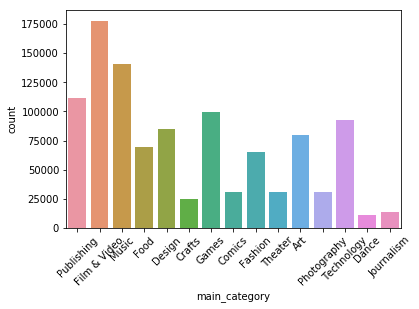

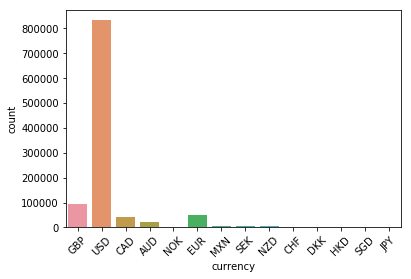

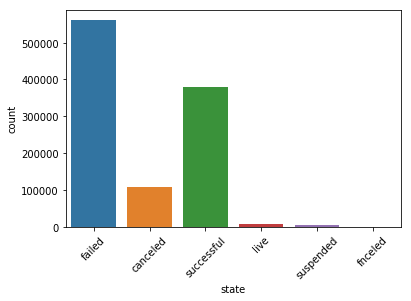

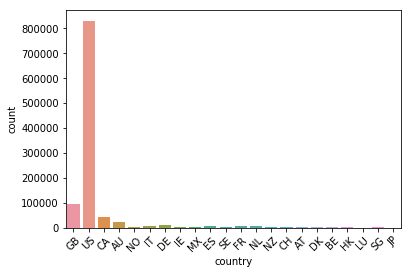

In [118]:
catCols = ['main_category','currency','state','country']
for col in catCols:
    g = sns.countplot(x=dfNum[col],data=dfNum)
    plt.setp(g.get_xticklabels(), rotation=45)
    plt.show()

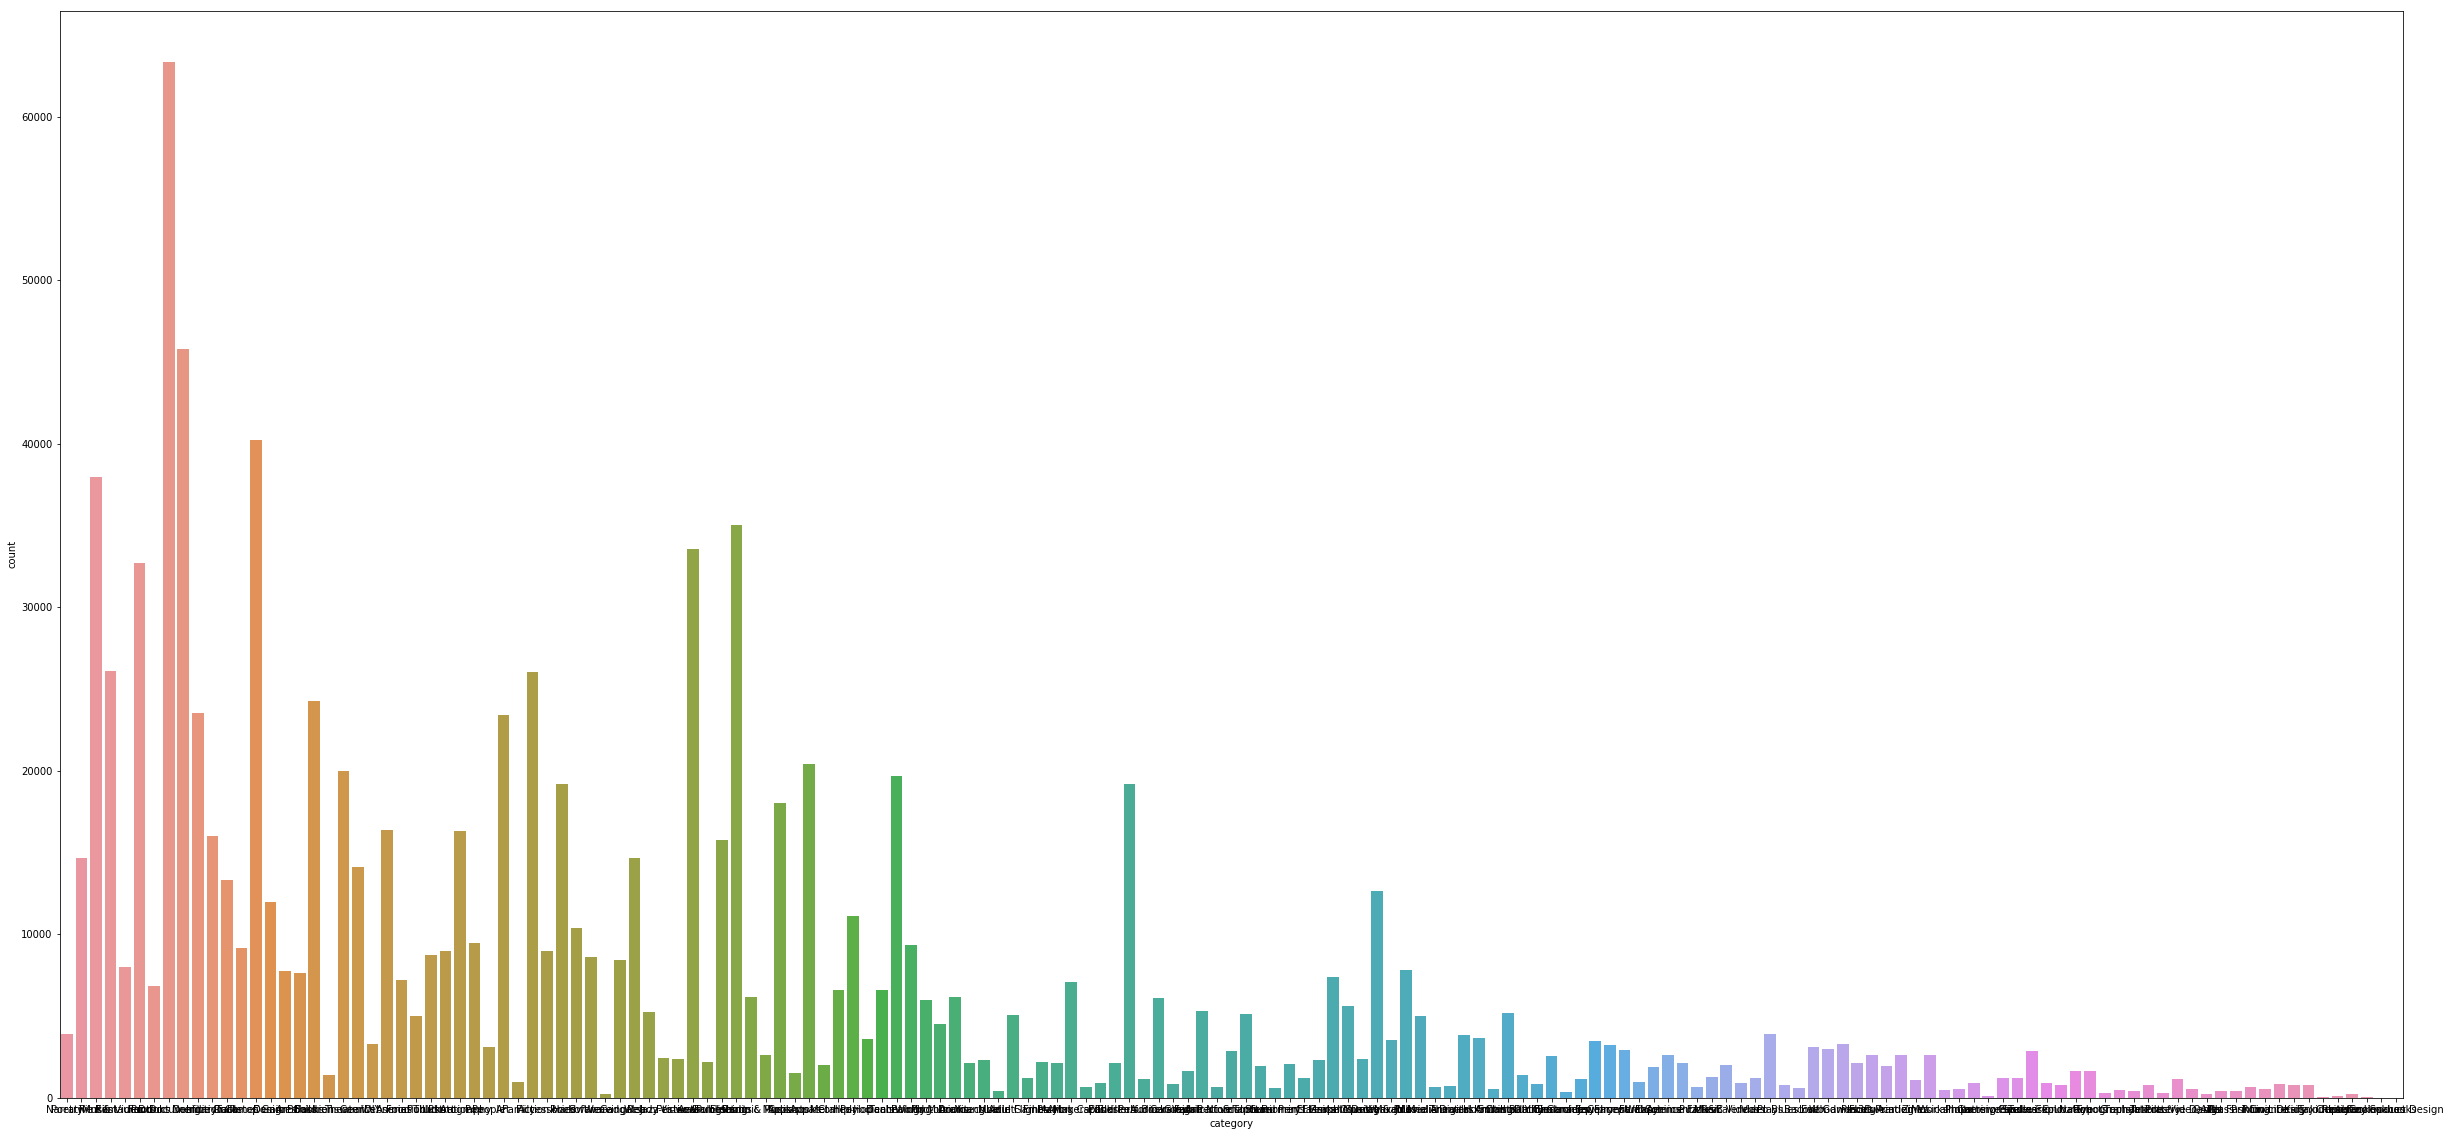

In [129]:
plt.figure(figsize=(42,20))
plt.setp(g.get_xticklabels(), rotation=45)
g = sns.countplot(x=dfNum['category'],data=dfNum)
plt.show()

In [130]:
np.unique(dfNum['category'])

array(['3D Printing', 'Academic', 'Accessories', 'Action', 'Animals',
       'Animation', 'Anthologies', 'Apparel', 'Apps', 'Architecture',
       'Art', 'Art Books', 'Audio', 'Bacon', 'Blues', 'Calendars',
       'Camera Equipment', 'Candles', 'Ceramics', "Children's Books",
       'Childrenswear', 'Chiptune', 'Civic Design', 'Classical Music',
       'Comedy', 'Comic Books', 'Comics', 'Community Gardens',
       'Conceptual Art', 'Cookbooks', 'Cookookbooks', 'Cookroduct Design',
       'Country & Folk', 'Couture', 'Crafts', 'Crochet', 'DIY',
       'DIY Electronics', 'Dance', 'Design', 'Digital Art', 'Documentary',
       'Drama', 'Drinks', 'Electronic Music', 'Embroidery', 'Events',
       'Experimental', 'Fabrication Tools', 'Faith', 'Family', 'Fantasy',
       "Farmer's Markets", 'Farms', 'Fashion', 'Festivals', 'Fiction',
       'Film & Video', 'Fine Art', 'Flight', 'Food', 'Food Trucks',
       'Footwear', 'Gadgets', 'Games', 'Gaming Hardware', 'Glass',
       'Graphic Design', 

In [133]:
def BoxHist(column, df_focus):
    
    sns.set()
    colList = df_focus[column]
    
    # plots
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=column, data=df_focus)
    
    plt.subplot(1, 2, 2)
    g=sns.distplot(colList, kde=False, bins=10)
    
    # rotate label for large tick values on histagram x axis
    if (colList.max() > 9999):
        plt.setp(g.get_xticklabels(), rotation=45)

    plt.show()

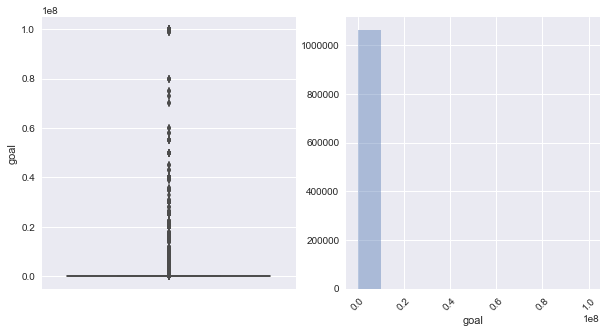

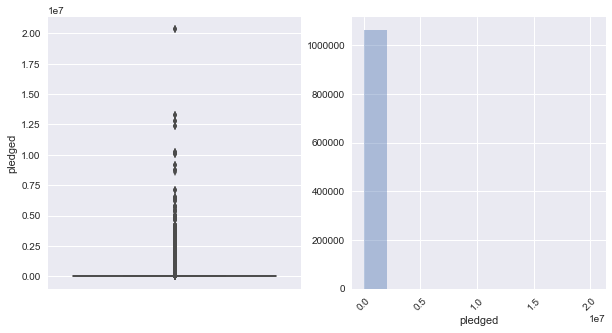

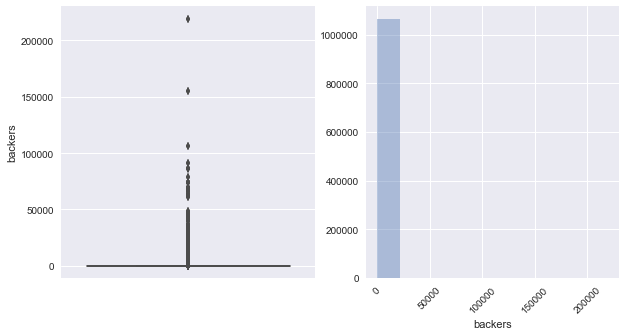

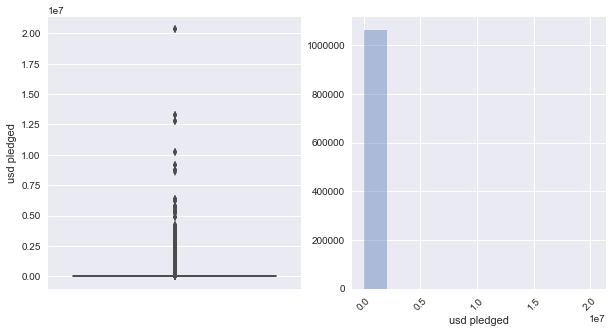

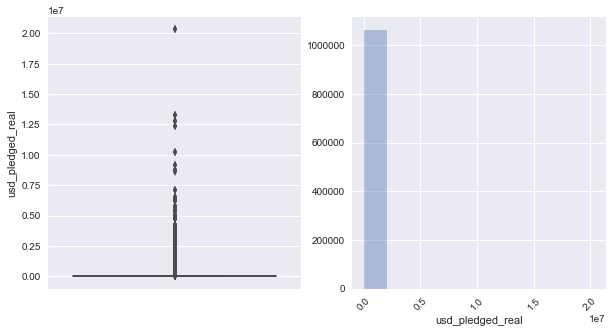

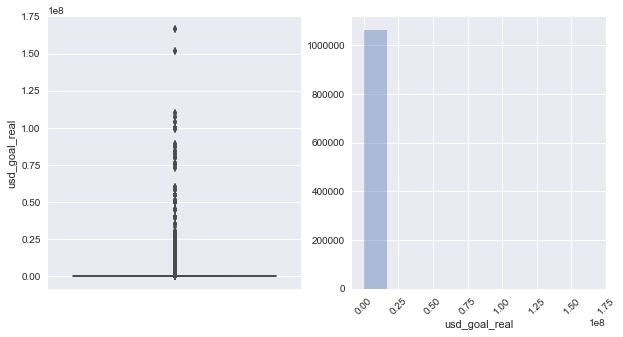

In [134]:
contCols = ['goal','pledged','backers','usd pledged', 'usd_pledged_real', 'usd_goal_real']
for col in contCols:
    BoxHist(col,dfNum)

# Bivariate Exploration

In [131]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283,1283.0,19500.00


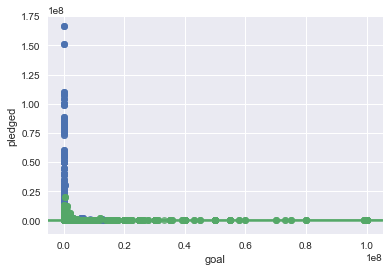

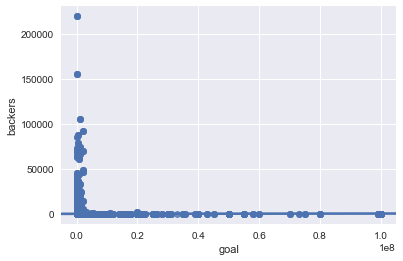

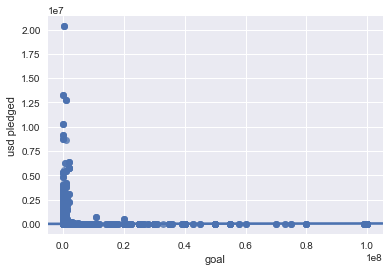

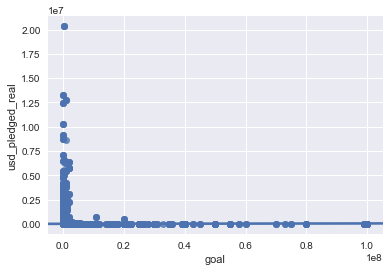

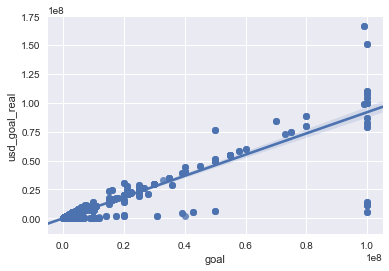

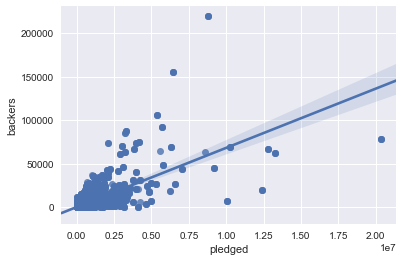

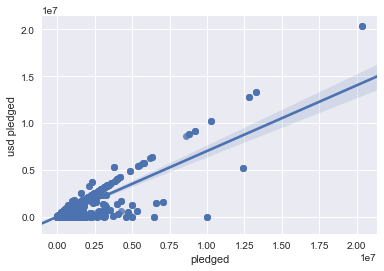

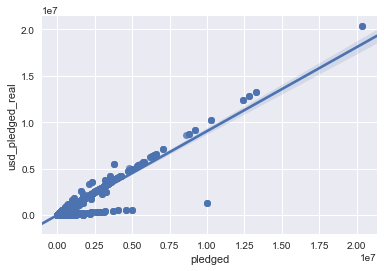

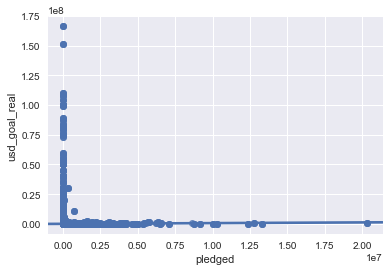

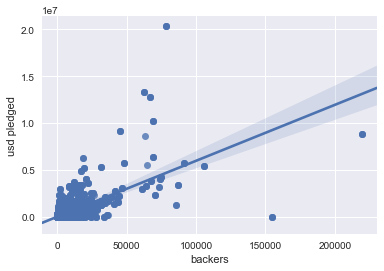

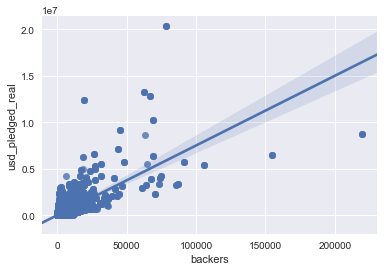

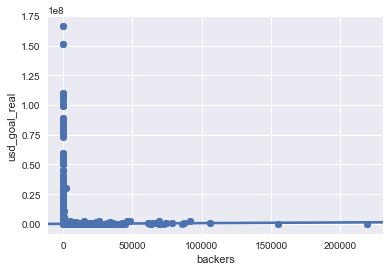

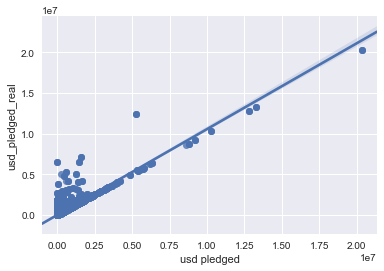

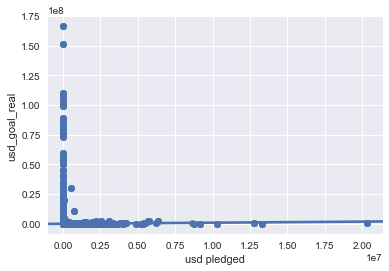

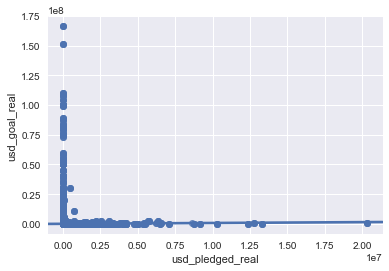

In [137]:
graphlog = []
for colx in contCols:
    for coly in contCols:
        logItem = coly+colx
        if (colx != coly) & (colx+coly not in graphlog):
            ax = sns.regplot(x=colx,y=coly, data=dfNum)
            graphlog.append(coly+colx)
            plt.show()
# Remove duplicates (Collect pairs, check before running graph)

# Feature Engineering 

### Length of Campaign

# Models 

In [138]:
y=dfNum['state']
X=dfNum[contCols]

In [ ]:
params = {'n_estimators':range(50,100,10),
         'max_depth': range(1,4),
         'loss':('deviance','exponential')}
gb = ensemble.GradientBoostingClassifier()
gs = GridSearchCV(gb, params, return_train_score=True)
gs.fit(X,y)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [ ]:
crossVal = cross_val_score(gb, X, y, cv=10)
fig = plt.figure()
title = "Performance: %s" % ('Gradient Boost')
fig.suptitle(title)
ax = fig.add_subplot(111)
plt.boxplot(crossVal)
ax.set_xticklabels(title)
plt.show()
print ('ACCURACY: {}'.format(crossVal.mean()))
print ('RANGE: {}'.format(crossVal.max() - crossVal.min()))
print ('CROSSVAL SCORES:\n {}'.format(crossVal))